In [2]:
# Install necessary libraries
!pip install shap

# Import necessary libraries
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV

# Un-comment once libs installing clean
# clear_output()

# Check XGBoost version
print(f"XGBoost version: {xgb.__version__}")

# Check other library versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"SHAP version: {shap.__version__}")

# Set up plotting styles
# plt.style.use('seaborn')
# sns.set_palette("viridis")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.9 MB/s eta 0:00:00
XGBoost version: 2.1.1
NumPy version: 1.26.4
Pandas version: 2.1.4
Scikit-learn version: 1.3.2
SHAP version: 0.46.0


# Load in data

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the folder
seamap_path = '/content/drive/MyDrive/ColabNotebooks/seamap_survey'

# Check if the path exists, and adjust if it doesn't
if not os.path.exists(seamap_path):
    seamap_path = '/content/drive/MyDrive/seamap_survey/'  # Ensure this path is correct

# Use the variable to change directory
%cd $seamap_path

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1QT3TfXsCu6j2HwKUeQ8-kOZitEMg55iO/seamap_survey


In [4]:
# Load the dataset into a Pandas DataFrame
# %ls $seamap_path

df = pd.read_csv(os.path.join(seamap_path, 'dataframes/BIODIV_health_metrics.csv'))

In [5]:
df.columns

Index(['DATE', 'unique_bio_count', 'cntexp_vector', 'PRECIP_mean',
       'PRECIP_std', 'DEPTH_ESRF_mean', 'DEPTH_ESRF_std', 'DEPTH_EMID_mean',
       'DEPTH_EMID_std', 'DEPTH_EMAX_mean', 'DEPTH_EMAX_std',
       'DEPTH_EWTR_mean', 'DEPTH_EWTR_std', 'DEPTH_SSTA_mean',
       'DEPTH_SSTA_std', 'DEPTH_ESTA_mean', 'DEPTH_ESTA_std', 'TEMPSURF_mean',
       'TEMPSURF_std', 'TEMPMID_mean', 'TEMPMID_std', 'TEMPMAX_mean',
       'TEMPMAX_std', 'TEMP_SSURF_mean', 'TEMP_SSURF_std', 'TEMP_BOT_mean',
       'TEMP_BOT_std', 'TEMP_SAIR_mean', 'TEMP_SAIR_std', 'SALSURF_mean',
       'SALSURF_std', 'SALMID_mean', 'SALMID_std', 'SALMAX_mean', 'SALMAX_std',
       'CHLORSURF_mean', 'CHLORSURF_std', 'CHLORMID_mean', 'CHLORMID_std',
       'CHLORMAX_mean', 'CHLORMAX_std', 'OXYSURF_mean', 'OXYSURF_std',
       'OXYMID_mean', 'OXYMID_std', 'OXYMAX_mean', 'OXYMAX_std',
       'TURBSURF_mean', 'TURBSURF_std', 'TURBMID_mean', 'TURBMID_std',
       'TURBMAX_mean', 'TURBMAX_std', 'WIND_SPD_mean', 'WIND_SPD_std',

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 76 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DATE                     3403 non-null   object 
 1   unique_bio_count         3403 non-null   int64  
 2   cntexp_vector            3403 non-null   object 
 3   PRECIP_mean              2743 non-null   float64
 4   PRECIP_std               2710 non-null   float64
 5   DEPTH_ESRF_mean          3274 non-null   float64
 6   DEPTH_ESRF_std           3243 non-null   float64
 7   DEPTH_EMID_mean          3371 non-null   float64
 8   DEPTH_EMID_std           3337 non-null   float64
 9   DEPTH_EMAX_mean          3385 non-null   float64
 10  DEPTH_EMAX_std           3351 non-null   float64
 11  DEPTH_EWTR_mean          3399 non-null   float64
 12  DEPTH_EWTR_std           3365 non-null   float64
 13  DEPTH_SSTA_mean          3403 non-null   float64
 14  DEPTH_SSTA_std          

# Clean up data and drop columns

In [7]:
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
# Extracting components from the 'DATE' column
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek
dropped_df = df.drop(columns=['DATE'])

dropped_df = dropped_df.drop(columns=df.filter(like='_std').columns)
dropped_df = dropped_df.drop(columns=['unique_bio_count', 'cntexp_vector', 'SAMPLE_BGS_mean'])
dropped_df = dropped_df.drop(columns=['START_DATE_mean', 'END_DATE_mean', 'DECELAT_mean', 'DECELON_mean'])

dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PRECIP_mean              2743 non-null   float64
 1   DEPTH_ESRF_mean          3274 non-null   float64
 2   DEPTH_EMID_mean          3371 non-null   float64
 3   DEPTH_EMAX_mean          3385 non-null   float64
 4   DEPTH_EWTR_mean          3399 non-null   float64
 5   DEPTH_SSTA_mean          3403 non-null   float64
 6   DEPTH_ESTA_mean          3286 non-null   float64
 7   TEMPSURF_mean            3373 non-null   float64
 8   TEMPMID_mean             3358 non-null   float64
 9   TEMPMAX_mean             3371 non-null   float64
 10  TEMP_SSURF_mean          3366 non-null   float64
 11  TEMP_BOT_mean            3362 non-null   float64
 12  TEMP_SAIR_mean           3330 non-null   float64
 13  SALSURF_mean             3357 non-null   float64
 14  SALMID_mean             

# Prepare Feature and Target columns

In [8]:
# Specify the target column names
target_columns = [
    "Shannon_entropy",
    "Pielou_evenness",
    "Simpson_diversity",
    "balance_metric",
    "adjusted_balance_metric"
]

# Define the feature columns (all columns except the targets and 'DATE')
feature_columns = dropped_df.columns.difference(target_columns + ['DATE'])

# Split features and targets
X = dropped_df[feature_columns]
y = dropped_df[target_columns]

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CHLORMAX_mean    2287 non-null   float64
 1   CHLORMID_mean    2078 non-null   float64
 2   CHLORSURF_mean   2800 non-null   float64
 3   DAY              3403 non-null   int32  
 4   DAY_OF_WEEK      3403 non-null   int32  
 5   DECSLAT_mean     3403 non-null   float64
 6   DECSLON_mean     3403 non-null   float64
 7   DEPTH_EMAX_mean  3385 non-null   float64
 8   DEPTH_EMID_mean  3371 non-null   float64
 9   DEPTH_ESRF_mean  3274 non-null   float64
 10  DEPTH_ESTA_mean  3286 non-null   float64
 11  DEPTH_EWTR_mean  3399 non-null   float64
 12  DEPTH_SSTA_mean  3403 non-null   float64
 13  MONTH            3403 non-null   int32  
 14  OXYMAX_mean      3347 non-null   float64
 15  OXYMID_mean      3332 non-null   float64
 16  OXYSURF_mean     3352 non-null   float64
 17  PRECIP_mean   

In [10]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Shannon_entropy          3403 non-null   float64
 1   Pielou_evenness          3403 non-null   float64
 2   Simpson_diversity        3403 non-null   float64
 3   balance_metric           3403 non-null   float64
 4   adjusted_balance_metric  3403 non-null   float64
dtypes: float64(5)
memory usage: 133.1 KB


# Training MultiRegressor XGBoost

In [11]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor()

# Wrap the XGBoost model with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(xgb_model)

# Train the model
multi_output_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = multi_output_model.predict(X_test_scaled)

# Evaluation: Calculate RMSE and R² for each target
for i, col in enumerate(target_columns):
    rmse = mean_squared_error(y_test[col], y_pred[:, i], squared=False)
    r2 = r2_score(y_test[col], y_pred[:, i])
    print(f"{col}: RMSE = {rmse:.3f}, R² = {r2:.3f}")


Shannon_entropy: RMSE = 0.525, R² = 0.427
Pielou_evenness: RMSE = 0.128, R² = 0.102
Simpson_diversity: RMSE = 0.142, R² = 0.280
balance_metric: RMSE = 0.097, R² = 0.448
adjusted_balance_metric: RMSE = 0.360, R² = 0.084


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize seaborn
sns.set(style="whitegrid")


Shannon_entropy: MAE = 0.420, RMSE = 0.525, R² = 0.427
Pielou_evenness: MAE = 0.097, RMSE = 0.128, R² = 0.102
Simpson_diversity: MAE = 0.101, RMSE = 0.142, R² = 0.280
balance_metric: MAE = 0.075, RMSE = 0.097, R² = 0.448
adjusted_balance_metric: MAE = 0.289, RMSE = 0.360, R² = 0.084


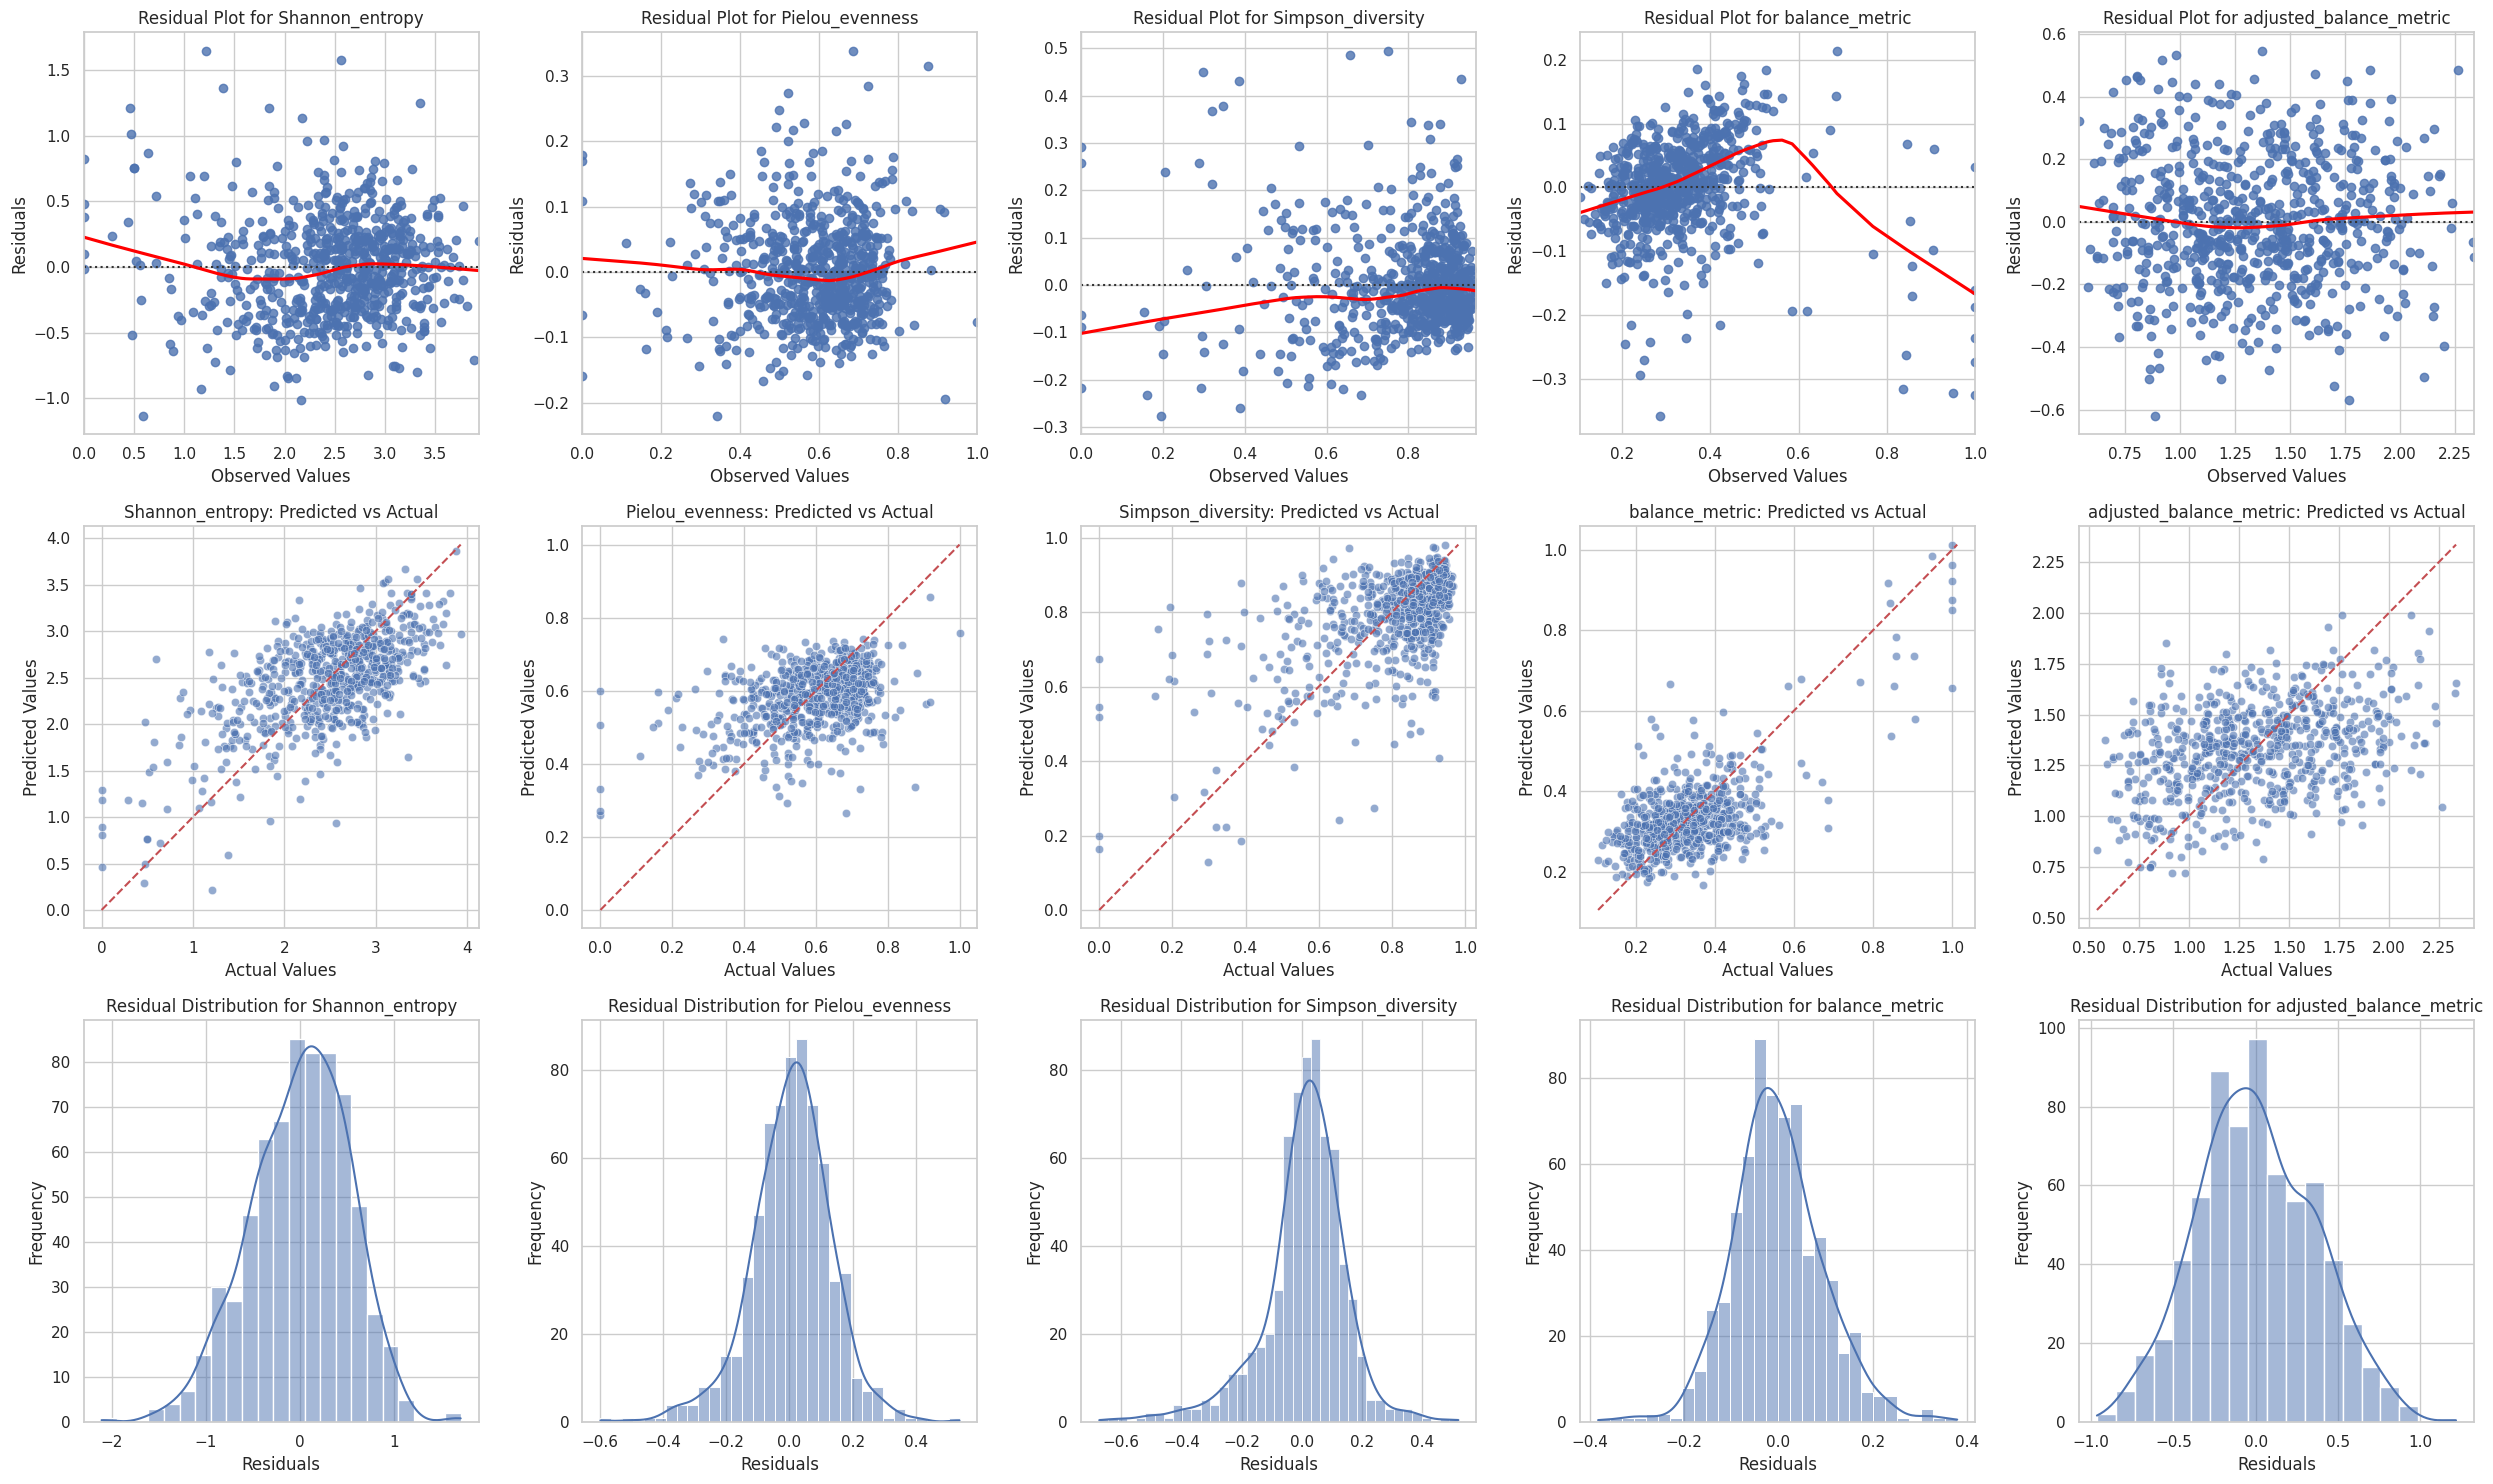

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize seaborn
sns.set(style="whitegrid")

# Number of targets
n_targets = len(target_columns)

# Create a 3xN subplot figure
fig, axes = plt.subplots(3, n_targets, figsize=(5*n_targets, 15))

for i, col in enumerate(target_columns):
    # Residual plot
    residuals = y_test[col] - y_pred[:, i]
    sns.residplot(x=y_test[col], y=residuals, lowess=True, line_kws={'color': 'red'}, ax=axes[0, i])
    axes[0, i].set_title(f'Residual Plot for {col}')
    axes[0, i].set_xlabel('Observed Values')
    axes[0, i].set_ylabel('Residuals')

    # y_pred vs y_actual scatter plot
    sns.scatterplot(x=y_test[col], y=y_pred[:, i], alpha=0.6, ax=axes[1, i])
    max_val = max(max(y_test[col]), max(y_pred[:, i]))
    min_val = min(min(y_test[col]), min(y_pred[:, i]))
    axes[1, i].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[1, i].set_title(f'{col}: Predicted vs Actual')
    axes[1, i].set_xlabel('Actual Values')
    axes[1, i].set_ylabel('Predicted Values')

    # Histogram of residuals
    sns.histplot(residuals, kde=True, ax=axes[2, i])
    axes[2, i].set_title(f'Residual Distribution for {col}')
    axes[2, i].set_xlabel('Residuals')
    axes[2, i].set_ylabel('Frequency')

    # Print additional metrics
    mae = mean_absolute_error(y_test[col], y_pred[:, i])
    rmse = mean_squared_error(y_test[col], y_pred[:, i], squared=False)
    r2 = r2_score(y_test[col], y_pred[:, i])
    print(f"{col}: MAE = {mae:.3f}, RMSE = {rmse:.3f}, R² = {r2:.3f}")

plt.tight_layout()
plt.show()


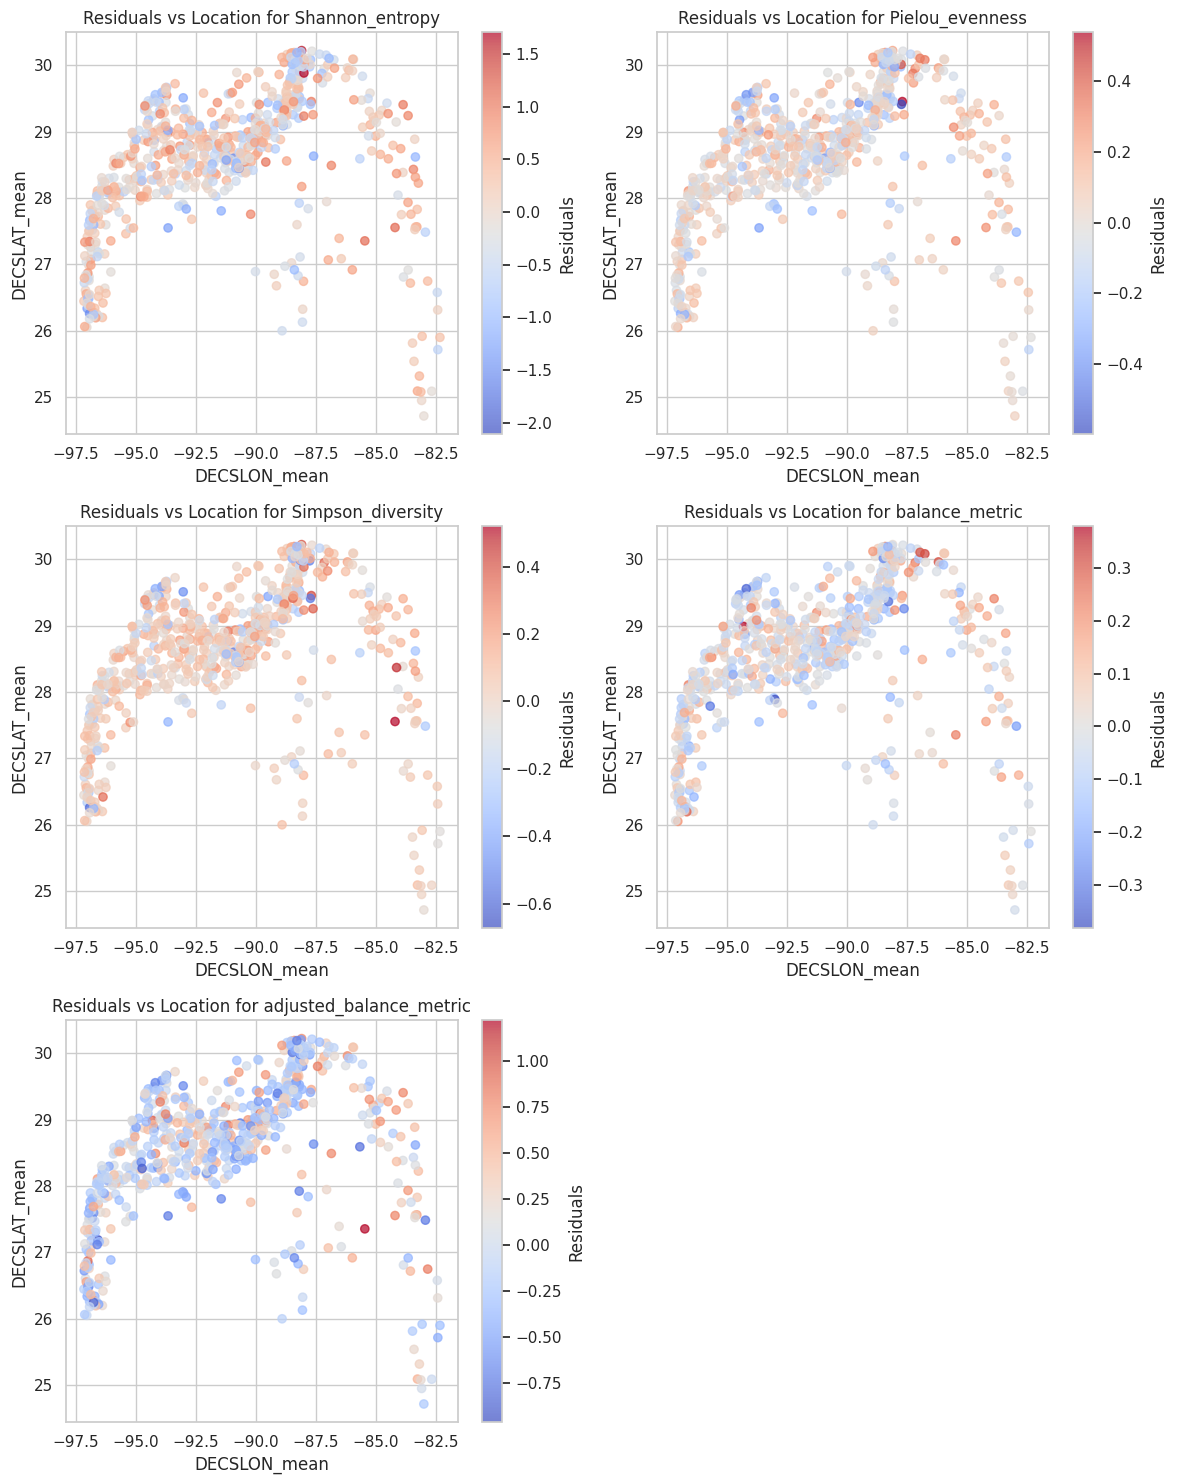

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of rows and columns for the subplot
n_rows = (len(target_columns) + 1) // 2  # This ensures 2 columns and N rows

# Create a 2-column by N-row subplot figure
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows))

# Flatten axes array for easy iteration in case of a 2D array
axes = axes.flatten()

for i, col in enumerate(target_columns):
    residuals = y_test[col] - y_pred[:, i]

    # Create the scatter plot for residuals vs location
    scatter = axes[i].scatter(
        df.loc[y_test.index, 'DECSLON_mean'],
        df.loc[y_test.index, 'DECSLAT_mean'],
        c=residuals, cmap='coolwarm', alpha=0.7
    )

    # Add color bar
    cbar = plt.colorbar(scatter, ax=axes[i])
    cbar.set_label('Residuals')

    # Set plot titles and labels
    axes[i].set_title(f'Residuals vs Location for {col}')
    axes[i].set_xlabel('DECSLON_mean')
    axes[i].set_ylabel('DECSLAT_mean')

# Hide any empty subplots if the number of targets is odd
if len(target_columns) % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


# Shannon Dataset

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CHLORMAX_mean    2287 non-null   float64
 1   CHLORMID_mean    2078 non-null   float64
 2   CHLORSURF_mean   2800 non-null   float64
 3   DAY              3403 non-null   int32  
 4   DAY_OF_WEEK      3403 non-null   int32  
 5   DECSLAT_mean     3403 non-null   float64
 6   DECSLON_mean     3403 non-null   float64
 7   DEPTH_EMAX_mean  3385 non-null   float64
 8   DEPTH_EMID_mean  3371 non-null   float64
 9   DEPTH_ESRF_mean  3274 non-null   float64
 10  DEPTH_ESTA_mean  3286 non-null   float64
 11  DEPTH_EWTR_mean  3399 non-null   float64
 12  DEPTH_SSTA_mean  3403 non-null   float64
 13  MONTH            3403 non-null   int32  
 14  OXYMAX_mean      3347 non-null   float64
 15  OXYMID_mean      3332 non-null   float64
 16  OXYSURF_mean     3352 non-null   float64
 17  PRECIP_mean   

In [16]:
target_column = 'Shannon_entropy'
y_Shannon = y[target_column]
y_Shannon.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3403 entries, 0 to 3402
Series name: Shannon_entropy
Non-Null Count  Dtype  
--------------  -----  
3403 non-null   float64
dtypes: float64(1)
memory usage: 26.7 KB


## Train, Validation, Test splits

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
# Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_Shannon, test_size=0.1, random_state=42)

# Further split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)  # 0.25 x 0.8 = 0.2

# Standard scaling for X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(X_test)

# Convert y to numpy array and reshape
y_train_numpy = y_train.to_numpy().reshape(-1, 1)
y_valid_numpy = y_valid.to_numpy().reshape(-1, 1)
y_test_numpy = y_test.to_numpy().reshape(-1, 1)

# Standard scaling for y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_numpy).flatten()
y_valid_scaled = scaler_y.transform(y_valid_numpy).flatten()


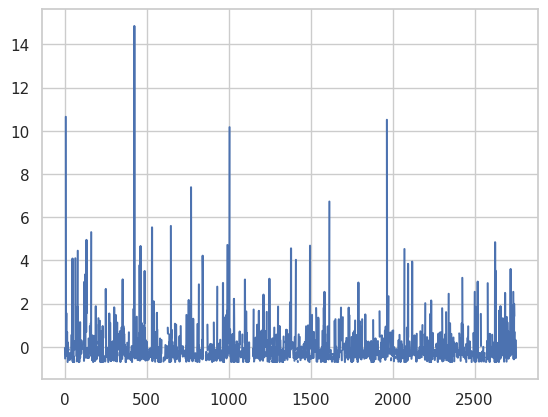

In [19]:
plt.plot(X_train_scaled[:,0])

In [20]:
#  Create a summary table of the number of entries
summary_data = {
    'Dataset': ['X_train', 'X_valid', 'X_test'],
    'Number of Entries': [
        len(X_train),
        len(X_valid),
        len(X_test)
    ]
}

pd.DataFrame(summary_data)

,Dataset,Number of Entries
0,X_train,2755
1,X_valid,307
2,X_test,341


# XGBoost

In [41]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

## Single model

RMSE = 0.527, R² = 0.396


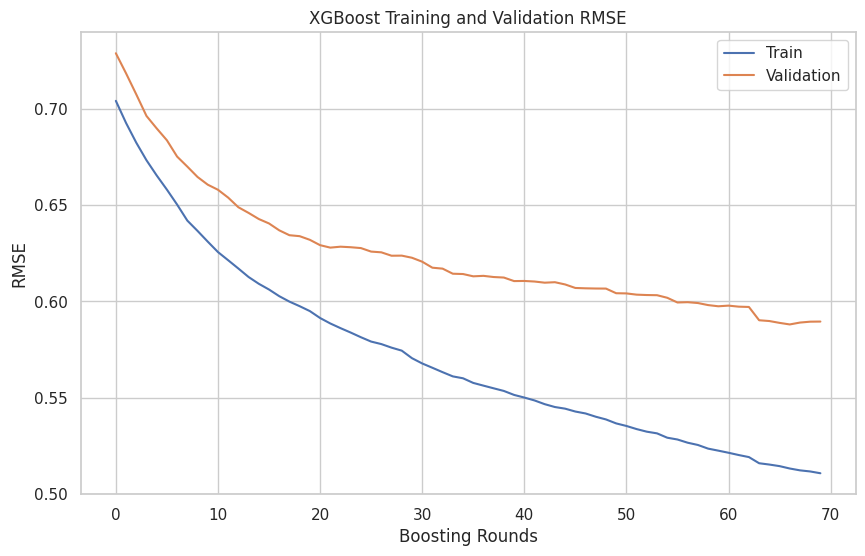

In [42]:
import matplotlib.pyplot as plt

# Define the model parameters explicitly
params = {
    'eval_metric': 'rmse',
    'n_estimators': 70,         # Number of boosting rounds
    'max_depth': 3,              # Maximum tree depth for base learners
    'learning_rate': 0.1,        # Step size shrinkage
    'subsample': 0.8,            # Subsample ratio of the training instances
    'colsample_bytree': 0.8,     # Subsample ratio of columns when constructing each tree
    'objective': 'reg:squarederror'  # Regression objective
}

# Initialize the XGBoost model with explicit parameters
xgb_model = xgb.XGBRegressor(**params)

# Train the model with evaluation set
eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
xgb_model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

# Predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Evaluation: Calculate RMSE and R² on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE = {rmse:.3f}, R² = {r2:.3f}")

# Plot training and validation RMSE
results = xgb_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

### Pred vs Actual & Residuals

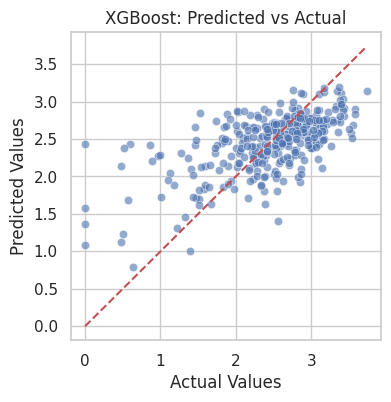

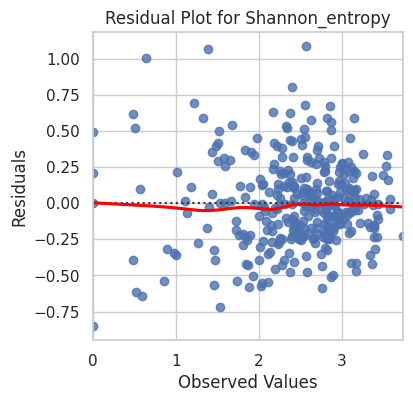

In [43]:
# Optional: Plotting y_pred vs y_actual
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title(f'XGBoost: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Optional: Residuals plot
plt.figure(figsize=(4, 4))
residuals = y_test - y_pred
sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title(f'Residual Plot for {target_column}')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.show()

### SHAP Analysis

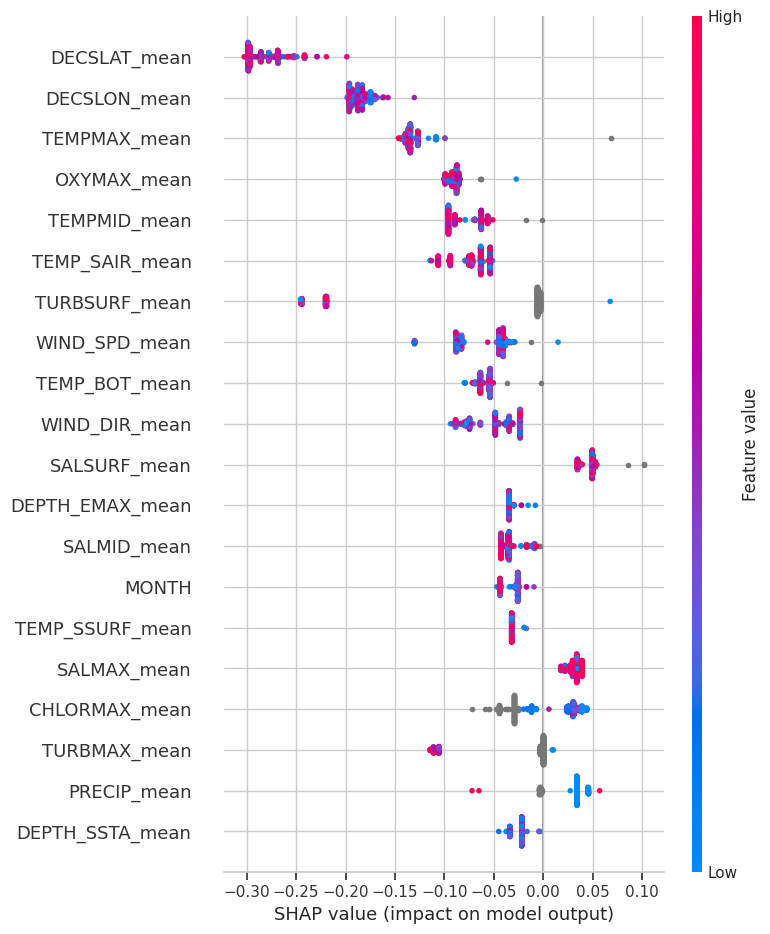

In [26]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

## Grid Search

In [27]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialize the XGBoost model with eval_metric
xgb_model = xgb.XGBRegressor(eval_metric="rmse")

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=5, verbose=1, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [29]:
# Predictions on the test set
y_pred = best_model.predict(X_test_scaled)

# Evaluation: Calculate RMSE and R² on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Best Model RMSE = {rmse:.3f}, R² = {r2:.3f}")


Best Model RMSE = 0.498, R² = 0.460


Model 1 parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Model 2 parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Model 3 parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


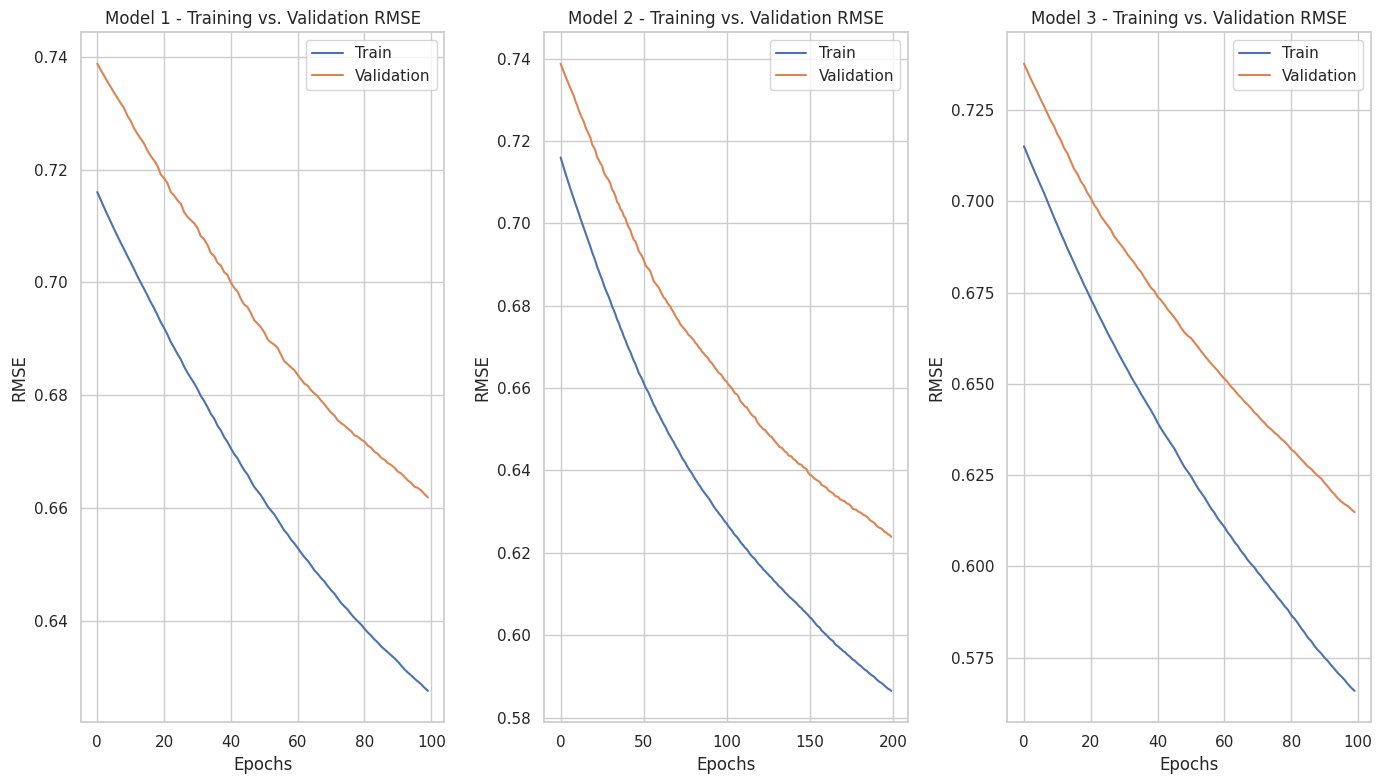

In [28]:
import matplotlib.pyplot as plt

# Get the top 3 models from the grid search results
results = grid_search.cv_results_
top_indices = np.argsort(results['mean_test_score'])[:3]

plt.figure(figsize=(14, 8))
for i, index in enumerate(top_indices, 1):
    params = results['params'][index]
    print(f"Model {i} parameters: {params}")

    # Train the model again with early stopping and record the evaluation history
    model = xgb.XGBRegressor(**params, eval_metric="rmse")
    eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
    model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

    # Extract training and validation scores
    eval_results = model.evals_result()
    epochs = len(eval_results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # Plot the learning curves
    plt.subplot(1, 3, i)
    plt.plot(x_axis, eval_results['validation_0']['rmse'], label='Train')
    plt.plot(x_axis, eval_results['validation_1']['rmse'], label='Validation')
    plt.title(f'Model {i} - Training vs. Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()

plt.tight_layout()
plt.show()


# Neural Network

In [38]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_valid_scaled = imputer.transform(X_valid_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0199 - mean_squared_error: 1.0199 - val_loss: 0.9177 - val_mean_squared_error: 0.9177
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8899 - mean_squared_error: 0.8899 - val_loss: 0.8548 - val_mean_squared_error: 0.8548
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8395 - mean_squared_error: 0.8395 - val_loss: 0.8373 - val_mean_squared_error: 0.8373
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7902 - mean_squared_error: 0.7902 - val_loss: 0.8154 - val_mean_squared_error: 0.8154
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7678 - mean_squared_error: 0.7678 - val_loss: 0.7839 - val_mean_squared_error: 0.7839
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7285 - mean_squared_error: 0.7285 - val_loss: 0.7631 - val_mean_squared_error: 0.7631
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7504 - mean_squared_error: 0.7504 - val_loss: 0.7528 - val_mean_squared_err

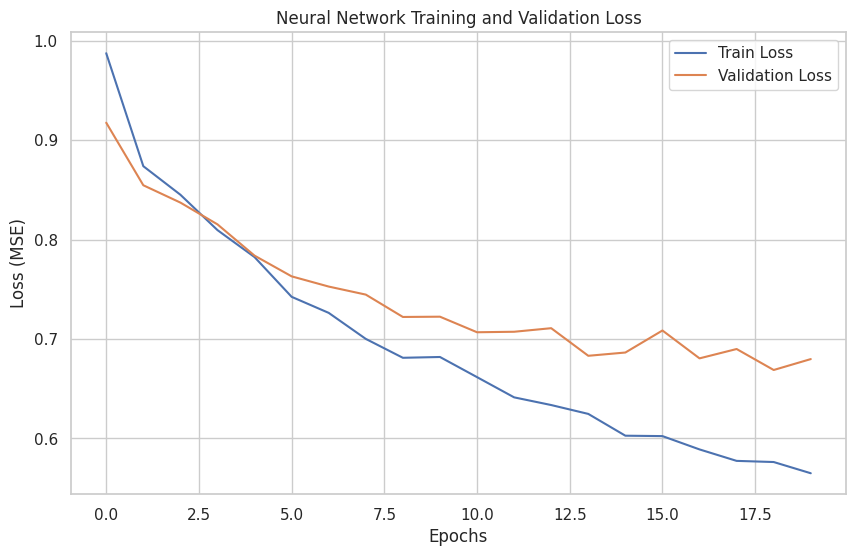

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the neural network model
NN_model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# Compile the model
NN_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with evaluation set
history = NN_model.fit(X_train_scaled, y_train_scaled, validation_data=(X_valid_scaled, y_valid_scaled),
                    epochs=20, batch_size=32, verbose=1)

# Predictions on the test set (still in the scaled format)
y_pred_scaled = NN_model.predict(X_test_scaled)

# Inverse transform the predictions to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluation: Calculate RMSE and R² on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE = {rmse:.3f}, R² = {r2:.3f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


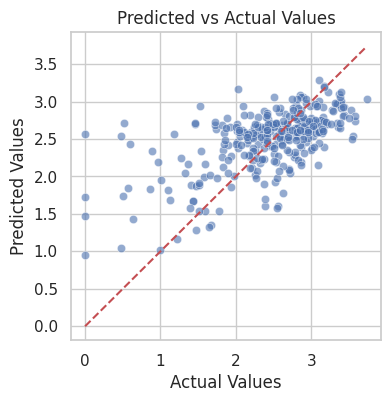

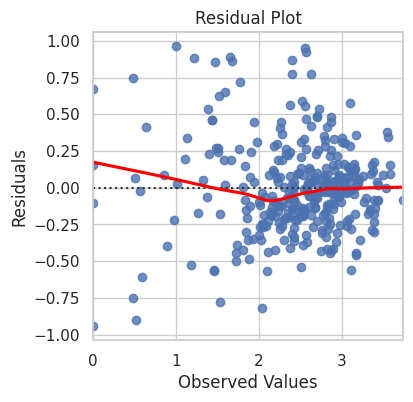

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Plotting y_pred vs y_actual
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Optional: Residuals plot
plt.figure(figsize=(4, 4))
residuals = y_test - y_pred.flatten()
sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.show()


# CNN

# Extract relevant features

In [44]:
# Original DataFrame with all features before scaling
original_columns = X_train.columns

# Define spatial and temporal feature groups based on column names
spatial_features = ['DECSLAT_mean', 'DECSLON_mean']
temporal_features = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK']

# Automatically identify additional features (the rest of the columns)
additional_features = [col for col in original_columns if col not in spatial_features + temporal_features]

# Extract feature indices automatically
spatial_indices = [original_columns.get_loc(col) for col in spatial_features]
temporal_indices = [original_columns.get_loc(col) for col in temporal_features]
additional_indices = [original_columns.get_loc(col) for col in additional_features]

# Extract the corresponding scaled features from the scaled datasets
X_train_spatial = X_train_scaled[:, spatial_indices]
X_valid_spatial = X_valid_scaled[:, spatial_indices]
X_test_spatial = X_test_scaled[:, spatial_indices]

X_train_time = X_train_scaled[:, temporal_indices]
X_valid_time = X_valid_scaled[:, temporal_indices]
X_test_time = X_test_scaled[:, temporal_indices]

X_train_numeric = X_train_scaled[:, additional_indices]
X_valid_numeric = X_valid_scaled[:, additional_indices]
X_test_numeric = X_test_scaled[:, additional_indices]

# Optionally check shapes
print(X_train_spatial.shape, X_train_time.shape, X_train_numeric.shape)

(2755, 2) (2755, 4) (2755, 27)


In [45]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Concatenate, Reshape, Conv2D, MaxPooling2D
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assume you've already extracted the feature groups: X_train_spatial, X_train_time, X_train_numeric, etc.

# Define input layers based on the sizes of the data
input_spatial = Input(shape=(X_train_spatial.shape[1],))  # Spatial features
input_time = Input(shape=(X_train_time.shape[1],))        # Temporal features
input_numeric = Input(shape=(X_train_numeric.shape[1],))  # Additional features

# Reshape and combine spatial and time inputs into a Conv1D layer if necessary
if X_train_spatial.shape[1] > 1 and X_train_time.shape[1] > 1:
    # # Concatenate spatial and temporal data
    # x = Concatenate()([input_spatial, input_time])
    # x = Reshape((x.shape[1], 1))(x)  # Reshape for Conv1D (samples, steps, channels)
    # x = Conv1D(64, kernel_size=3, activation='relu')(x)
    # x = MaxPooling1D(pool_size=2)(x)
    # x = Flatten()(x)

    # Reshape spatial and time data for Conv2D
    x = Concatenate()([input_spatial, input_time])
    x = Reshape((6, 1, 1))(x)  # Reshape for Conv2D

    # Apply Conv2D with kernel size (1,1) because it's now effectively 1D.
    x = Conv2D(64, kernel_size=(1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(1, 1))(x)
    x = Flatten()(x)
else:
    # If either spatial or temporal data is small or has a single feature, treat them separately
    x_spatial = Dense(32, activation='relu')(input_spatial)
    x_time = Dense(32, activation='relu')(input_time)
    x = Concatenate()([x_spatial, x_time])

# Combine with other numerical features
x = Concatenate()([x, input_numeric])

x = Dense(64, activation='relu')(x)  # Increased number of neurons
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)


output = Dense(1, activation='linear')(x)
# Define the model
CNN_model = Model(inputs=[input_spatial, input_time, input_numeric], outputs=output)

# Compile the model
CNN_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


In [46]:
# Train the model
history = CNN_model.fit(
    [X_train_spatial, X_train_time, X_train_numeric], y_train_scaled,
    validation_data=([X_valid_spatial, X_valid_time, X_valid_numeric], y_valid_scaled),
    epochs=50, batch_size=16, verbose=1
)

Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9531 - mean_squared_error: 0.9531 - val_loss: 0.8598 - val_mean_squared_error: 0.8598
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8443 - mean_squared_error: 0.8443 - val_loss: 0.8004 - val_mean_squared_error: 0.8004
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8589 - mean_squared_error: 0.8589 - val_loss: 0.7583 - val_mean_squared_error: 0.7583
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7691 - mean_squared_error: 0.7691 - val_loss: 0.7669 - val_mean_squared_error: 0.7669
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7373 - mean_squared_error: 0.7373 - val_loss: 0.7411 - val_mean_squared_error: 0.7411
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6767 - mean_squared_error: 0.6767 - val_loss: 0.7275 - val_mean_squared_error: 0.7275
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7065 - mean_squared_error: 0.7065 - val_loss: 0.70

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE = 0.514, R² = 0.426


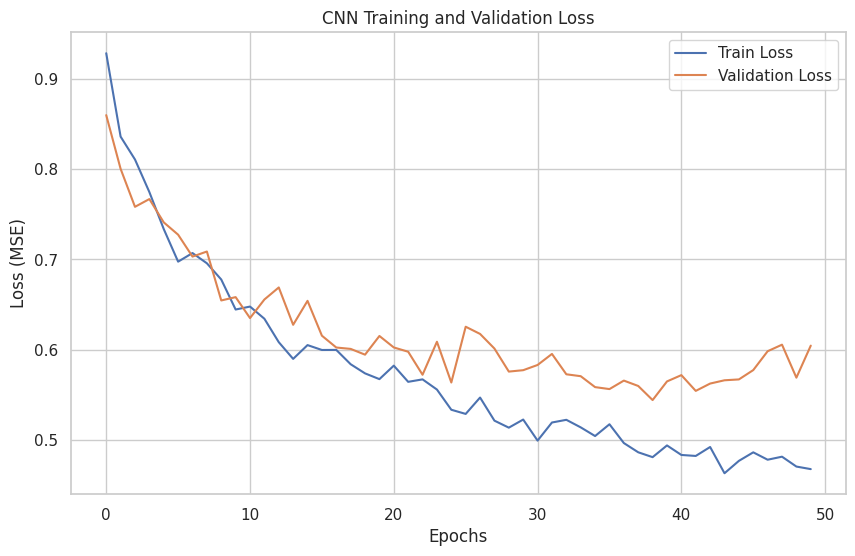

In [47]:
# Predictions on the test set (still in the scaled format)
y_pred_scaled = CNN_model.predict([X_test_spatial, X_test_time, X_test_numeric]).reshape(-1, 1)

# Inverse transform the predictions to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate the model using the original y_test values
rmse = mean_squared_error(y_test_numpy.flatten(), y_pred.flatten(), squared=False)
r2 = r2_score(y_test_numpy.flatten(), y_pred.flatten())

print(f"RMSE = {rmse:.3f}, R² = {r2:.3f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


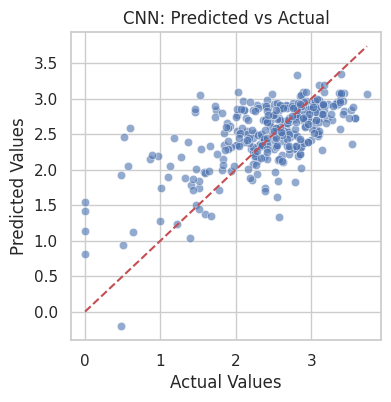

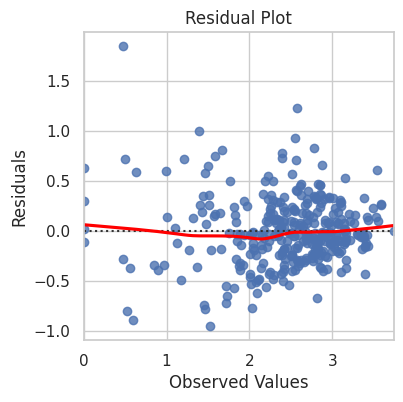

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Plotting y_pred vs y_actual
plt.figure(figsize=(4,4))
sns.scatterplot(x=y_test_numpy.flatten(), y=y_pred.flatten(), alpha=0.6)
plt.plot([min(y_test_numpy.flatten()), max(y_test_numpy.flatten())],
         [min(y_test_numpy.flatten()), max(y_test_numpy.flatten())], 'r--')
plt.title('CNN: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Optional: Residuals plot
plt.figure(figsize=(4,4))
residuals = y_test_numpy.flatten() - y_pred.flatten()
sns.residplot(x=y_test_numpy.flatten(), y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.show()


# Linear Regression

RMSE = 0.637, R² = 0.119


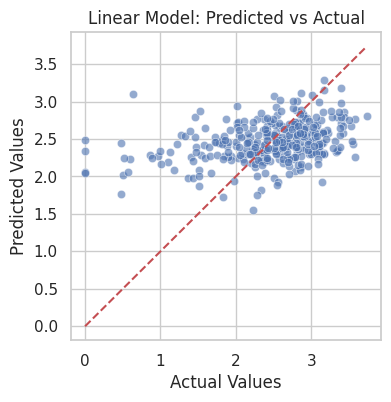

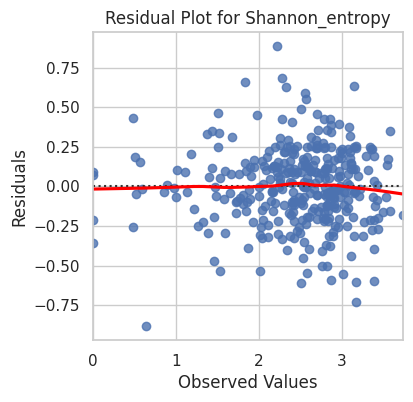

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
lin_reg_model = LinearRegression()

# Train the model
lin_reg_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = lin_reg_model.predict(X_test_scaled)

# Evaluation: Calculate RMSE and R² on the test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE = {rmse:.3f}, R² = {r2:.3f}")

# Since Linear Regression does not have multiple epochs,
# we will plot the predictions vs actual values instead.


# Optional: Plotting y_pred vs y_actual
plt.figure(figsize=(4, 4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title(f'Linear Model: Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Optional: Residuals plot
plt.figure(figsize=(4, 4))
residuals = y_test - y_pred
sns.residplot(x=y_test, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title(f'Residual Plot for {target_column}')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.show()
